In [1]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

PATH = "/mnt/d/Datasets/"
imgPATH = PATH + "mini-DDSM/MINI-DDSM-Complete-PNG-16/"
ddsm_roi_path = PATH + "mini-DDSM/ROI/"
vindr_roi_path = PATH+"/Vindr-Mammo/ROI/"
data_path = PATH + "mini-DDSM/fullimg/"
save_dir = "/home/jj/FYP/Models/"
combined_path = PATH + "combined/"
image_size = 300
batch_size = 16
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

2023-02-02 23:28:49.961164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 23:28:49.974766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 23:28:49.974814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# load ddsm

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  ddsm_roi_path,
#   label_mode="categorical",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  ddsm_roi_path,
#   label_mode="categorical",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 2830 files belonging to 2 classes.
Using 2264 files for training.
Found 2830 files belonging to 2 classes.
Using 566 files for validation.


2023-02-02 23:28:50.094140: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 23:28:50.095103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 23:28:50.095154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 23:28:50.095170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

# load vindr

In [4]:
# train_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)
# val_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)

# combined

In [5]:
# train_combined = tf.keras.utils.image_dataset_from_directory(
#   combined_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=1)
# val_combined = tf.keras.utils.image_dataset_from_directory(
#   combined_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=1)

In [6]:
preprocessing = preprocess_input
pre_trained = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,1)),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0),width_factor=(-0.5,0)),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25))
  ])
#Define model architect
tfinput = Input(shape=(image_size,image_size,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
efficientnetv2m_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(efficientnetv2m_model)
DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(1024,activation = 'relu')(DO1)
x=Dropout(0.7)(Dense1)
x = Dense(512,activation='relu')(x)
DO2 = Dropout(0.7)(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
# def prepare(ds, shuffle=False, augment=False,batch_size=32):
#   # # Resize and rescale all datasets.
  
#   data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
#   tf.keras.layers.RandomRotation((0,0.3),fill_mode="constant"),
#   tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
#   tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
#   ])
#   if shuffle:
#     ds = ds.shuffle(1000)

  
#   # ds = ds.batch(batch_size)

#   # Use data augmentation only on the training set.
#   if augment:
#     # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#     #           num_parallel_calls=AUTOTUNE)
#     ds = ds.map(lambda x, y: (data_augmentation(x,training=True),y), 
#                 num_parallel_calls=AUTOTUNE)
#   # Batch all datasets.
  
#   # print(ds)
#   # Use buffered prefetching on all datasets.
#   return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# train_ds_aug = prepare(train_ds,shuffle=True,augment=True,batch_size=1)
# val_ds_aug = prepare(val_ds,batch_size=1)
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_aug= val_ds.prefetch(buffer_size=AUTOTUNE)

# initialising

In [9]:
# init_lr = 1e-3
# steps = 1e3
# final_lr = 1e-4
# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
#                                                             ,steps
#                                                             ,final_lr
#                                                             ,power=0.5)

In [24]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/dense_init_checkpoint_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1311

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.8058 - binary_accuracy: 0.5278 - false_positives_1: 511.0000 - false_negatives_1: 558.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.53180, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/dense_init_checkpoint_2/cp-0001.ckpt
142/142 [==============================] - 34s 183ms/step - loss: 0.8058 - binary_accuracy: 0.5278 - false_positives_1: 511.0000 - false_negatives_1: 558.0000 - val_loss: 0.6771 - val_binary_accuracy: 0.5318 - val_false_positives_1: 260.0000 - val_false_negatives_1: 5.0000
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.7860 - binary_accuracy: 0.5318 - false_positives_1: 535.0000 - false_negatives_1: 525.0000
Epoch 2: val_binary_accuracy improved from 0.53180 to 0.59011, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/dense_init_checkpoint_2/cp-0002.ckpt
142/142 [==============================] - 24s 166ms/step - loss: 0.7860 - binary_accur

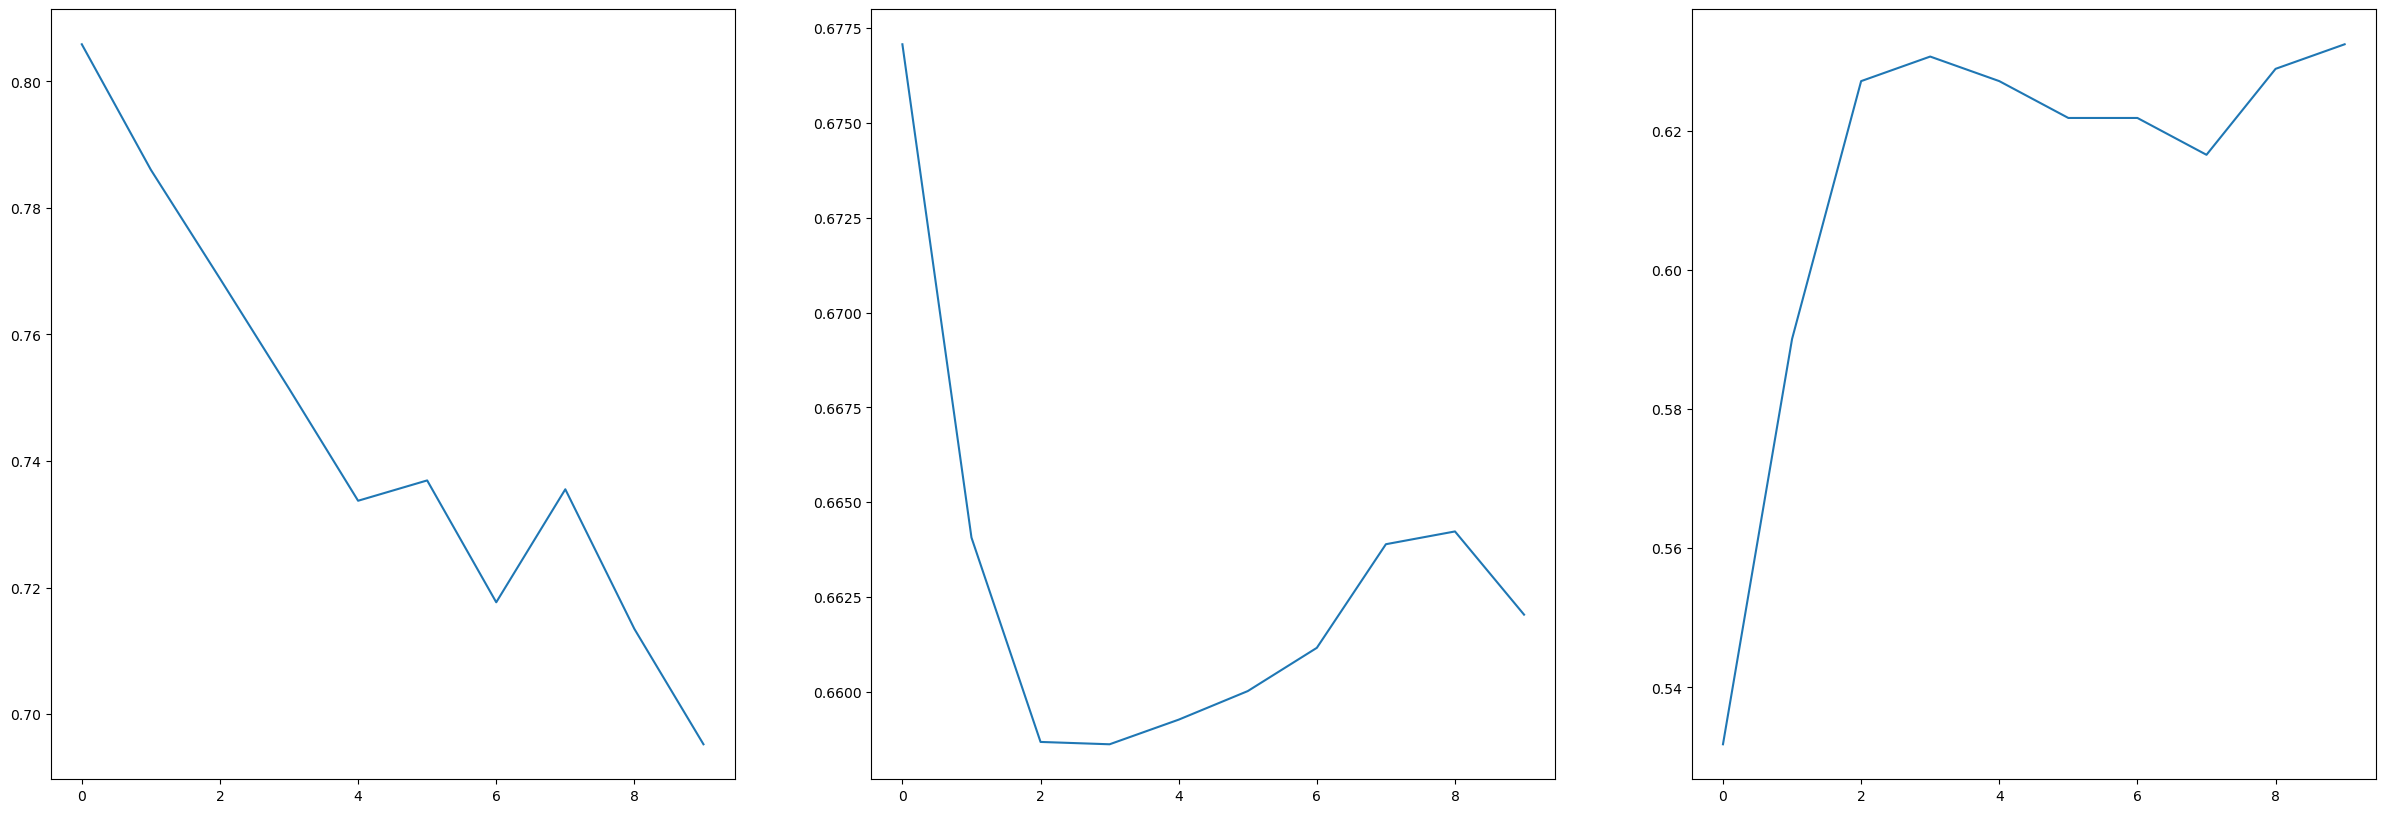

In [25]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 10
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_binary_accuracy'])

# fine tuning

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

2023-02-02 23:29:10.381758: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-02-02 23:29:12.397333: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 23:29:12.397387: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 23:29:12.410312: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

142/142 [==============================] - ETA: 0s - loss: 0.6598 - binary_accuracy: 0.6056
Epoch 1: val_loss improved from inf to 0.63587, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.63958, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-0001.ckpt
142/142 [==============================] - 43s 225ms/step - loss: 0.6598 - binary_accuracy: 0.6056 - val_loss: 0.6359 - val_binary_accuracy: 0.6396
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.6522 - binary_accuracy: 0.6038
Epoch 2: val_loss improved from 0.63587 to 0.62904, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-0002.ckpt

Epoch 2: val_binary_accuracy improved from 0.63958 to 0.64134, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-0002.ckpt
142/142 [=====================

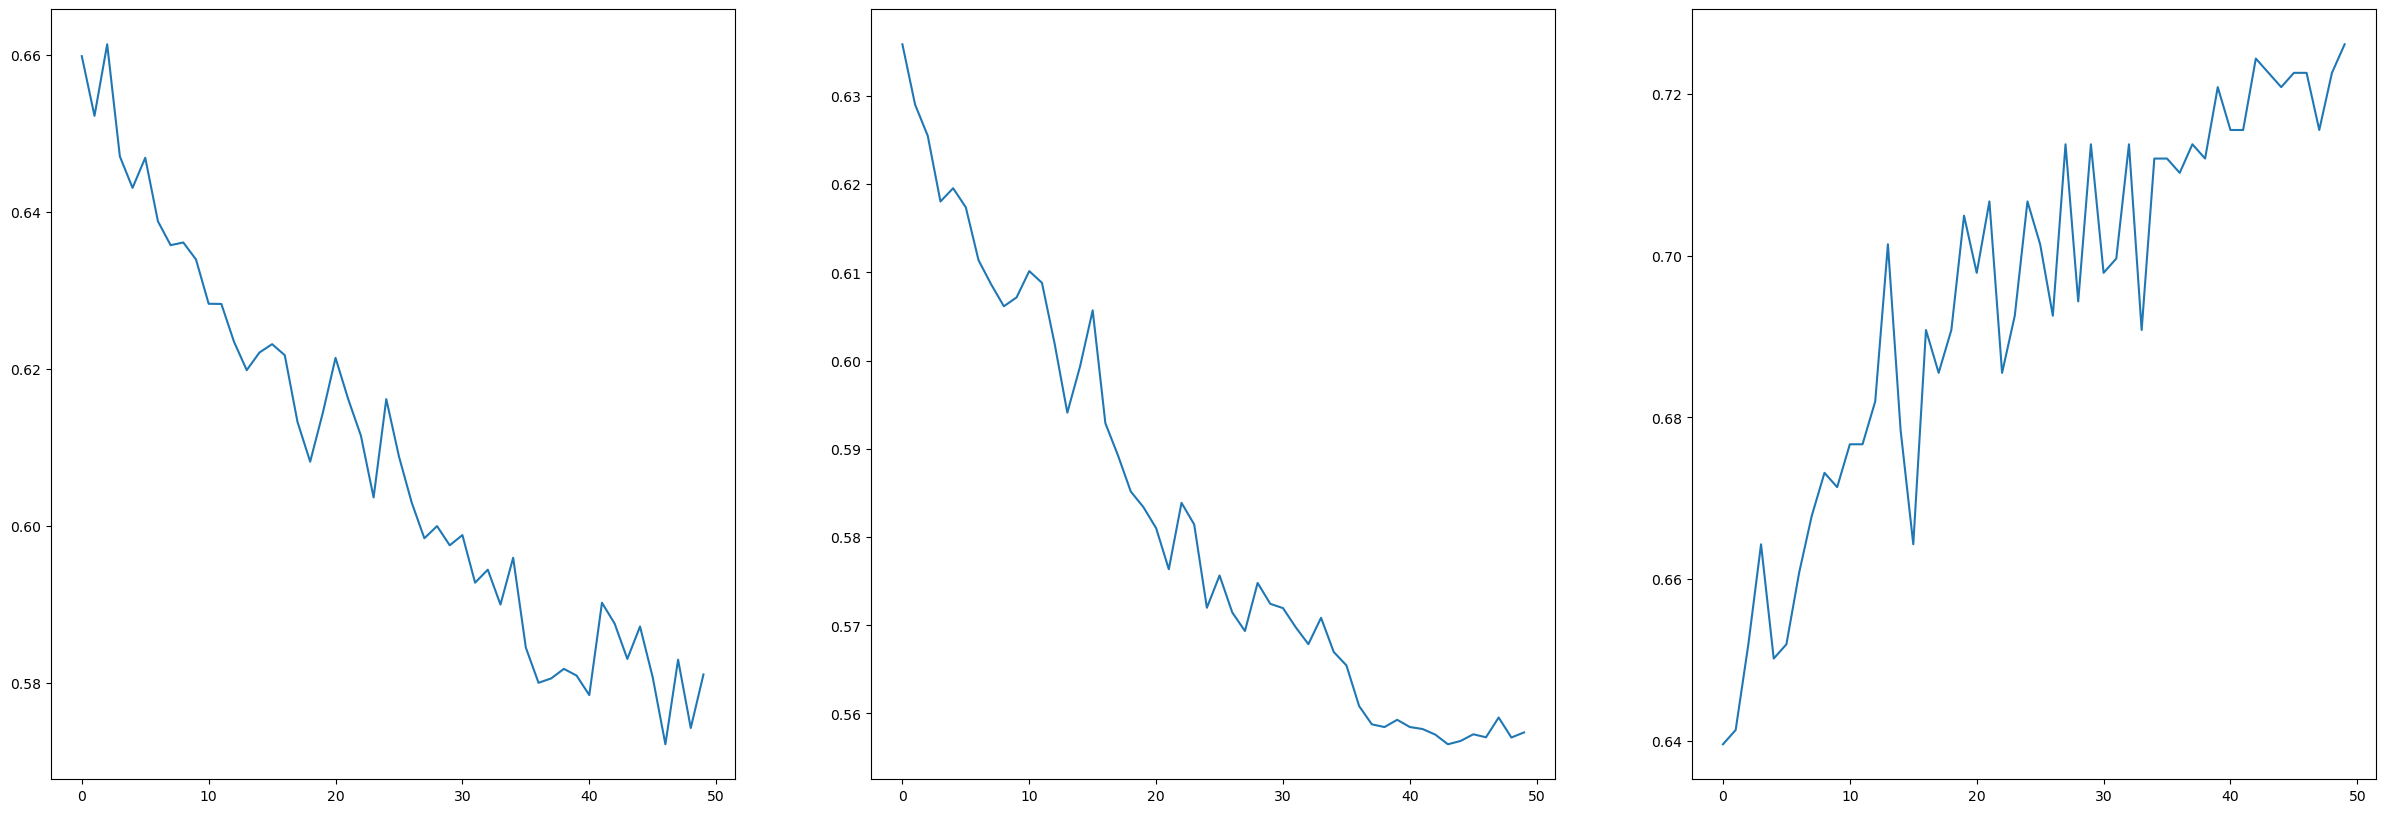

In [9]:
#load model with best performance
# model.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2')
model.load_weights(latest)

pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-75]:
  layer.trainable = False
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 50
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

In [12]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2')
model.load_weights(latest)
init_lr = 5e-6
steps = 100
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_3/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 50
history_ft_2 = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

Epoch 1/50
142/142 [==============================] - ETA: 0s - loss: 0.5728 - binary_accuracy: 0.6899
Epoch 1: val_loss improved from inf to 0.55857, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_3/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.71378, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_3/cp-0001.ckpt
142/142 [==============================] - 39s 215ms/step - loss: 0.5728 - binary_accuracy: 0.6899 - val_loss: 0.5586 - val_binary_accuracy: 0.7138
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.5728 - binary_accuracy: 0.7036
Epoch 2: val_loss improved from 0.55857 to 0.55692, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_3/cp-0002.ckpt

Epoch 2: val_binary_accuracy did not improve from 0.71378
142/142 [==============================] - 28s 192ms/step - loss: 0.5728 - binary_accuracy: 0.7036 - val_loss: 0.5569 - val_

KeyboardInterrupt: 

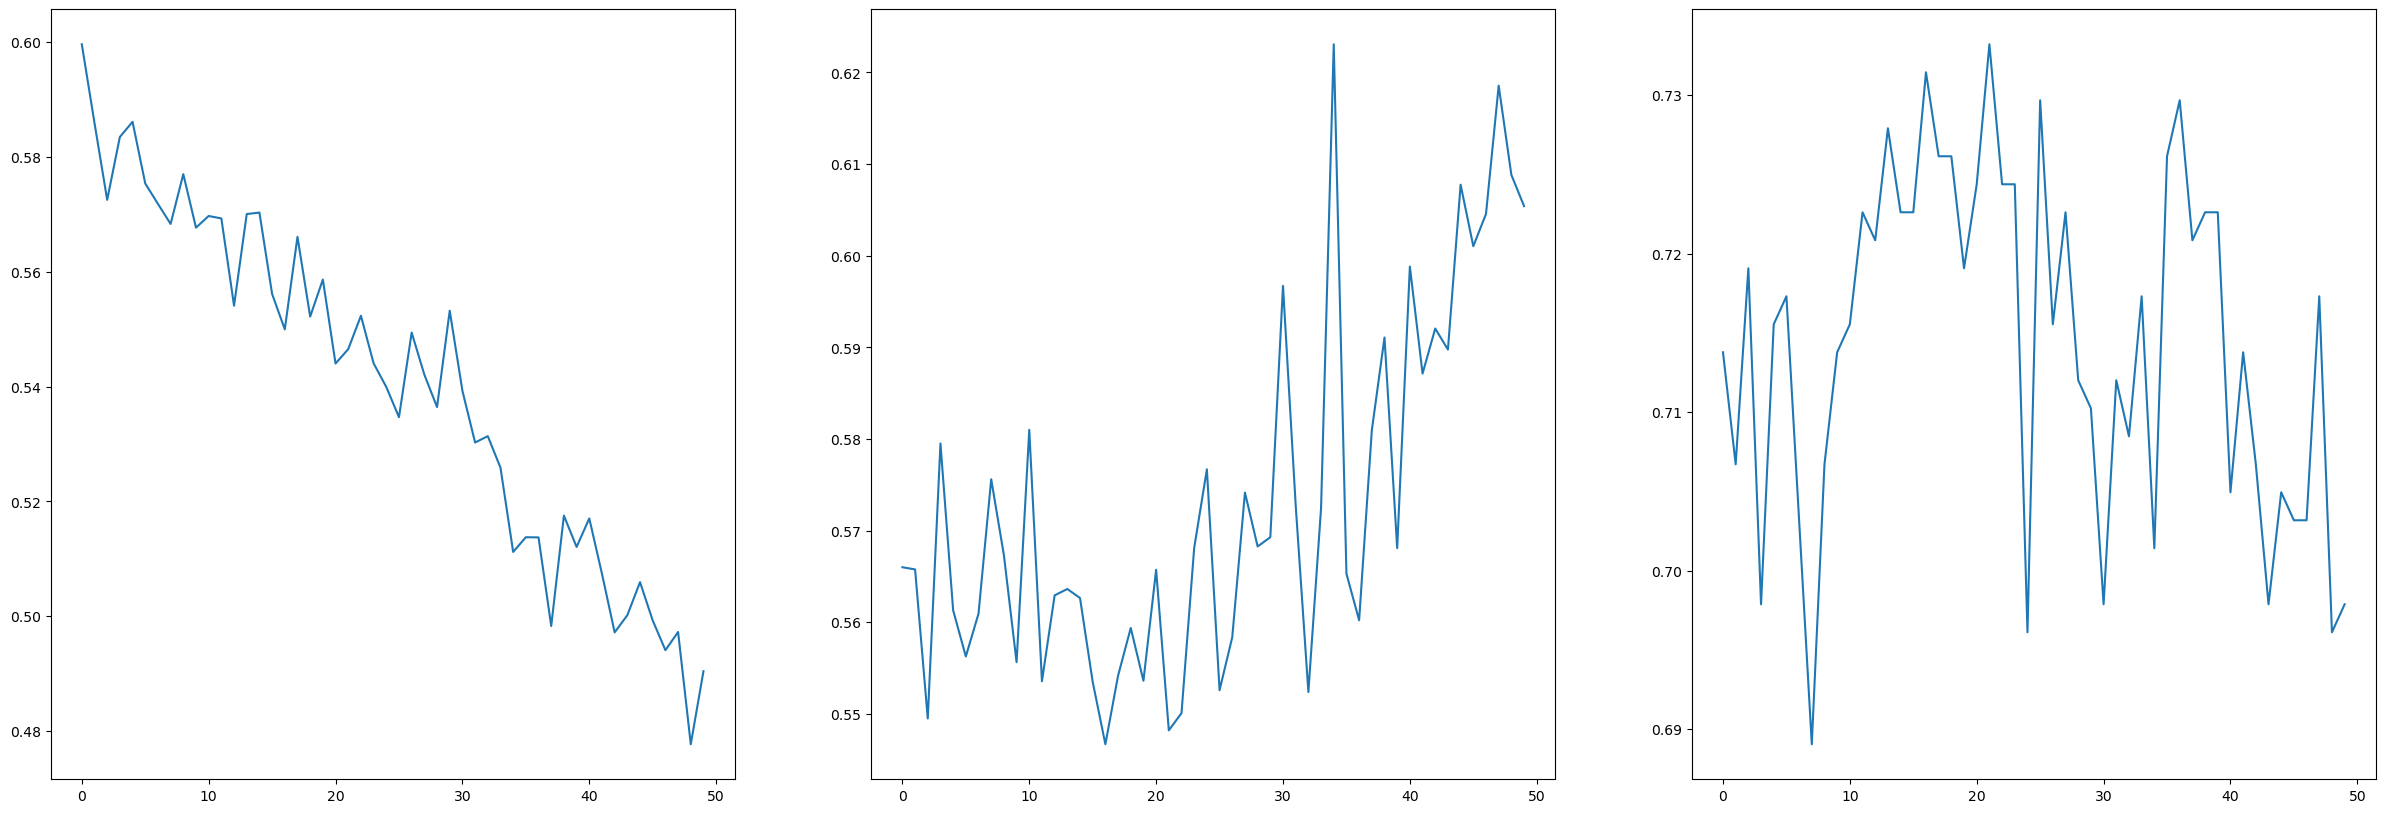

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_ft_2.history['loss'])
plt.subplot(132)
plt.plot(history_ft_2.history['val_loss'])
plt.subplot(133)
plt.plot(history_ft_2.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

2023-02-02 07:44:44.861360: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.861406: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.967682: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


142/142 [==============================] - ETA: 0s - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000
Epoch 1: val_loss improved from inf to 0.56650, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.72261, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-0001.ckpt
142/142 [==============================] - 79s 494ms/step - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000 - val_loss: 0.5665 - val_binary_accuracy: 0.7226 - val_false_positives_1: 72.0000 - val_false_negatives_1: 85.0000
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.5779 - binary_accuracy: 0.6921 - false_positives_1: 215.0000 - false_negatives_1: 482.0000
Epoch 2: val_loss improved from 0.56650 to 0.55574, saving model to /home/jj/FYP/Checkpoint/EfficientNet_d

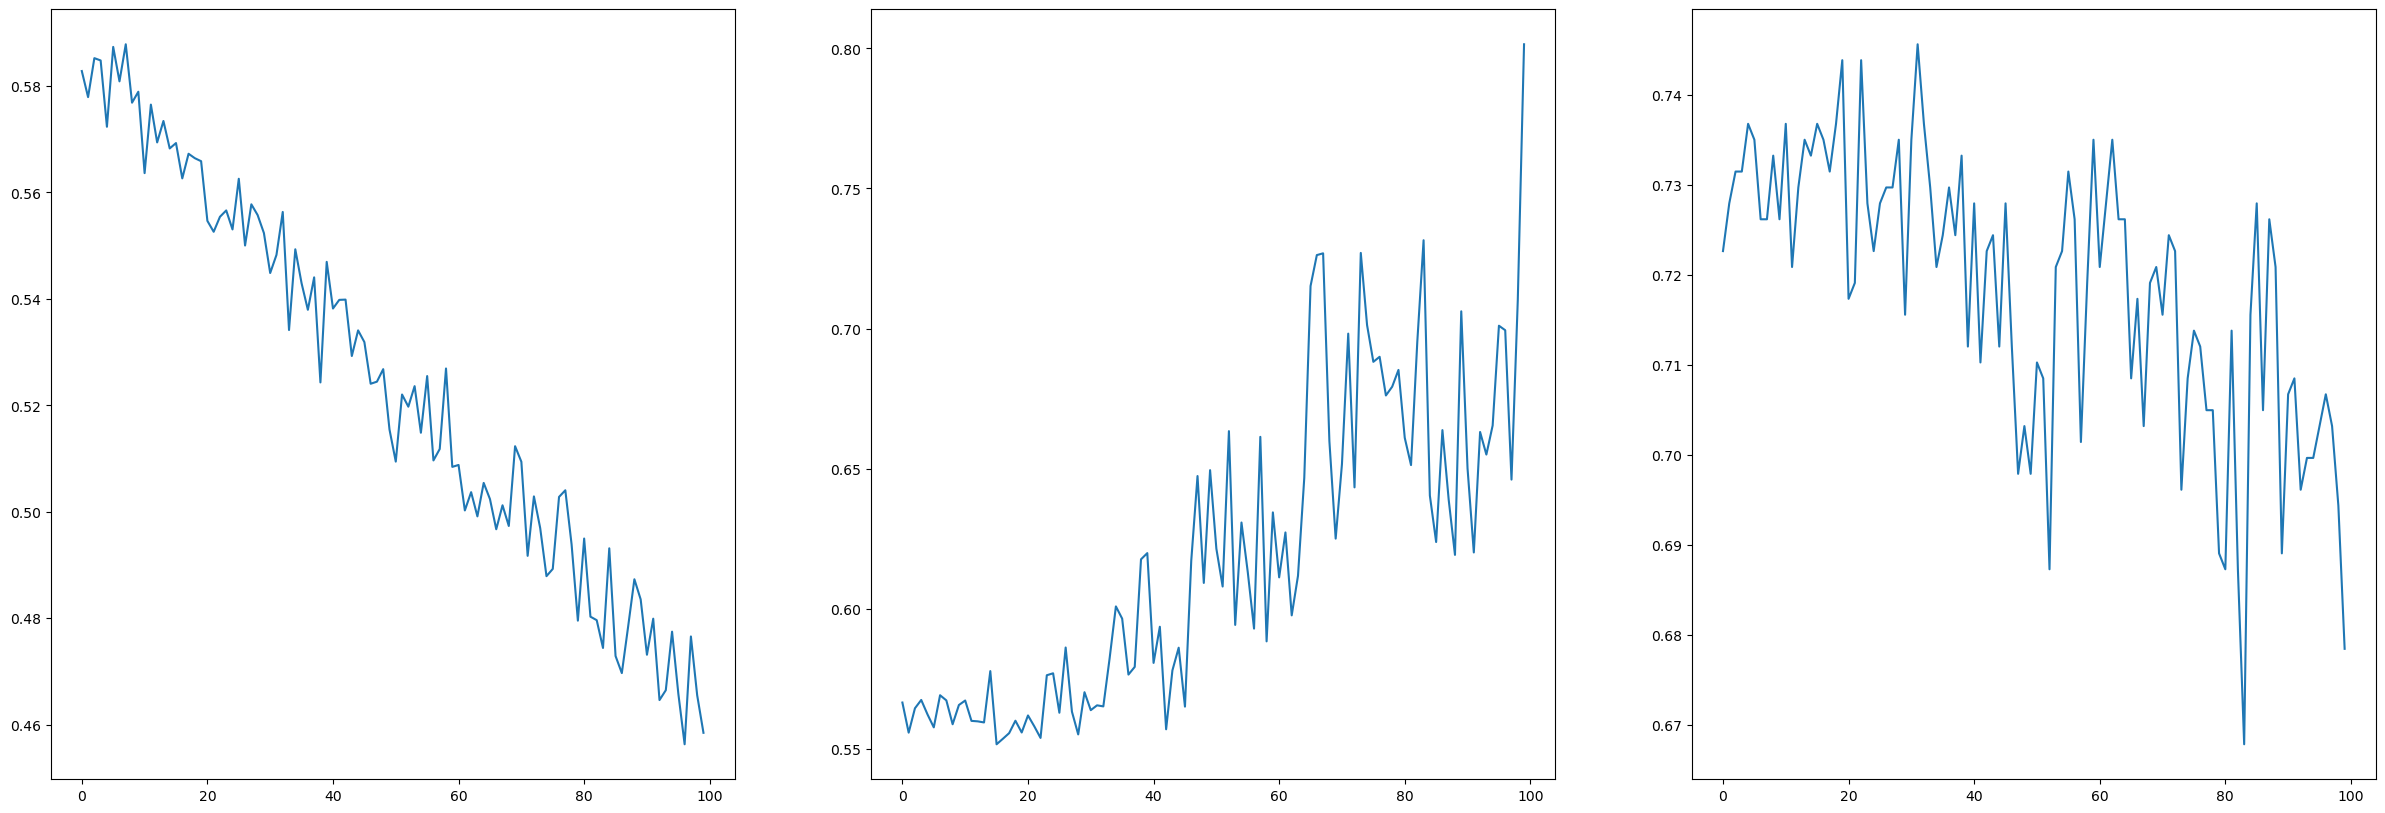

In [10]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss')
model.load_weights(latest)
init_lr = 5e-6
steps = 1e5
final_lr = 1e-7
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-150]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])